In [ ]:
import os
import pandas as pd
#processing the original data
def aggregate_df(dir_path):
    """dir_path: directory with different results csv files.
    Returns a single df where it aggregates all the files but only keeps One header row."""
    import os
    import pandas as pd

    all_files = [f for f in os.listdir(dir_path) if f.endswith('.csv')]
    dfs = []
    for file in all_files:
        file_path = os.path.join(dir_path, file)
        df = pd.read_csv(file_path)
        dfs.append(df)

    # Concatenate all DataFrames
    aggregated_df = pd.concat(dfs, ignore_index=True)
    #Drop the AC and SOC Formulations
    print("Before dropping AC and SOC Formulations:", aggregated_df.shape)
    #Find the amount of AC formulation in the aggregated_df
    ac_count = aggregated_df[aggregated_df['Formulation'] == 'AC'].shape[0]
    print(f"Number of AC entries: {ac_count}")
    
    #Find the amount of INFEASIBLE in the aggregated_df
    infeasible_count = aggregated_df[aggregated_df['Status'] == 'LOCALLY_INFEASIBLE'].shape[0]
    print(f"Number of INFEASIBLE entries: {infeasible_count}")
    print(ac_count - infeasible_count)
    aggregated_df = aggregated_df[~aggregated_df['Formulation'].str.contains('AC|SOC', regex=True)]
    #Drop the lines where there is not 4 entry for the given perturbation (group by perturbation and keep only those with 4 entries)
    aggregated_df = aggregated_df.groupby('perturbation').filter(lambda x: len(x) == 12)
    #Drop the perturbation column
    # Reset index and return
    return aggregated_df.reset_index(drop=True)

def to_decomp(Bool):
    """convert a boolean into true or false,weather merging the cliques or not."""
    if isinstance(Bool, pd.Series):
        return Bool.apply(lambda x: "true" if x else "false")
    else:
        if Bool:
            return "true"
        else:
            return "false"
        
def solve_times_per_profile_df(solver_df):
    """df: DataFrame with teh SolveTime for each Formulation and Merge for each perturbation.
    1. If there is no column "profile" : Creates a profile column with the name
    2. Creates a "decomp" column with the name of the decompositon
    3. Takes Each profile and create a New DataFrame with columns profile, d in decomp.unique and each case is the SolveTime for the given profile and decomp
    4. Returns the new DataFrame with the profile, decomp and the SolveTime
    """
    
    print(solver_df.columns)
    # --- C) Parse perturbation and build profile ID ---
    solver_df[["sigma", "raw_i"]] = (
        solver_df["perturbation"]
        .str.strip("()")
        .str.split(",", expand=True)
    )
    solver_df["sigma"] = solver_df["sigma"].astype(float)
    solver_df["raw_i"] = solver_df["raw_i"].astype(int)

    # Assuming your load‐profile filenames use i = raw_i // 2
    #Check if the column "load_id" exists, if not create it
    if "load_id" not in solver_df.columns:
        solver_df["profile"] = solver_df.apply(
            lambda r: f"{r['Case']}_{r['sigma']}_perturbation_{r['raw_i']}", axis=1
    )
    else:
        solver_df["profile"] = solver_df["load_id"]
    #Here, solver_df["A_parameter"], is a Float and we want to convert it to a decomp with formulation + A°_parameter
    solver_df["decomp"] = solver_df["Formulation"]+"_"+solver_df["A_parameter"].astype(str) 
    return solver_df

df = aggregate_df("/home/goatoine/Documents/Lanyue/data/Alpha")  # Adjust the path to your directory
sol = solve_times_per_profile_df(df)
print(sol.columns)
print(sol.shape)

def pivot_solve_times(df: pd.DataFrame,
                      profile_col: str = "profile",
                      decomp_col: str = "decomp",
                      value_col: str = "SolveTime") -> pd.DataFrame:
    """
    Pivot df so that each profile is one row, and each decomp strategy
    becomes its own column of solve times.

    Parameters
    ----------
    df
        Original DataFrame with one row per (profile, decomp) pair.
    profile_col
        Name of the column identifying each load profile.
    decomp_col
        Name of the column identifying the decomposition strategy (must have exactly 4 unique values per profile).
    value_col
        Name of the column to fill into the pivot (here SolveTime).

    Returns
    -------
    pd.DataFrame
        index: auto-generated, columns = [profile_col, decomp_1, decomp_2, …].
    """
    # pivot so that decomp values become columns
    pivot = df.pivot(index=profile_col,
                     columns=decomp_col,
                     values=value_col)

    # optional: ensure columns are sorted by decomp strategy
    pivot = pivot.reindex(sorted(pivot.columns), axis=1)

    # rename columns to something more explicit
    pivot.columns = [col for col in pivot.columns]

    # bring profile back as a column
    pivot = pivot.reset_index()

    return pivot

print("pivoting solve times")
pivot = pivot_solve_times(sol)
print(pivot.columns)
print(pivot.shape)




ModuleNotFoundError: No module named 'utils'

In [2]:
def features_from_df_Y(df_Y, load_dir):
    """df_Y : pd.DataFrame a dataframe with the cases and their labels
    load_dir: str, the directory where the load profiles are stored
    …
    Returns a DataFrame with the features for each case and their labels.
    """

    features = []
    cols = df_Y.columns.tolist()
    # identify all the 'Chordal_*' columns once
    chordal_cols = [c for c in cols if c.startswith("Chordal_")]

    for _, row in df_Y.iterrows():
        case = row['profile']

        # if you have a 'best_decomp' label column, handle it
        if "best_decomp" in cols:
            label = row['best_decomp']

        # Load the corresponding load profile
        load_file = os.path.join(load_dir, case)
        if not os.path.exists(load_file):
            print(f"Load file {load_file} does not exist. Skipping case {case}.")
            continue

        with open(load_file, 'r') as f:
            load_data = eval(f.read())
        #print(f"Processing case {case}")

        # build the feature dict for this case
        case_features = {}

        # extract pd, qd for each bus
        for bus_id, bus_data in load_data.items():
            case_features[f"pd_bus_{bus_id}"] = bus_data['pd']
            case_features[f"qd_bus_{bus_id}"] = bus_data['qd']

        # always include the case name
        case_features['case'] = case

        # add either the single 'best_decomp' label...
        if "best_decomp" in cols:
            case_features['label'] = label
        # ...or all the 'Chordal_*' columns dynamically
        else:
            for c in chordal_cols:
                case_features[c] = row[c]

        features.append(case_features)

    return pd.DataFrame(features)


# 查看文件夹中有多少个文件
load_dir = "/home/goatoine/Documents/Lanyue/data/networ_demand/pglib_opf_case2746wop_k_A"
# num_files = len(os.listdir(load_dir))
# print(f"{load_dir} 文件数: {num_files}")


df_2 = features_from_df_Y(pivot, load_dir)
#print(df_2.head())
print(df_2.shape)
print(df_2.columns)


NameError: name 'pivot' is not defined

In [ ]:
#save the DataFrame to a CSV file
output_file = "/home/goatoine/Documents/Lanyue/data/feature/XGboost/feature_alpha_profiles.csv"
df_2.to_csv(output_file, index=False)
print(f"DataFrame saved to {output_file}")

In [1]:
output_file = "/home/goatoine/Documents/Lanyue/data/feature/XGboost/feature_alpha_profiles.csv"
import pandas as pd

#Read the DataFrame from the CSV file
df_2 = pd.read_csv(output_file)
print(df_2.head())
print(df_2.columns)
#这步其实没起到作用，因为case本来就没重复 
print(df_2["case"].unique())
print(df_2.shape)

   pd_bus_306  qd_bus_306  pd_bus_1886  qd_bus_1886  pd_bus_1  qd_bus_1  \
0    0.076174    0.036590     0.051960     0.010170  0.021602  0.345318   
1    0.057682    0.044165     0.069578     0.008016  0.022868  0.370595   
2    0.054601    0.034653     0.047780     0.009802  0.020929  0.287435   
3    0.086365    0.039667     0.057291     0.010267  0.022208  0.353787   
4    0.087760    0.034225     0.045919     0.010700  0.015567  0.442957   

   pd_bus_519  qd_bus_519  pd_bus_788  qd_bus_788  ...  Chordal_AMD_2.5  \
0    0.036639    0.010596    0.007878         0.0  ...       112.729930   
1    0.043763    0.018687    0.006134         0.0  ...        98.443667   
2    0.045584    0.020037    0.007408         0.0  ...        99.570549   
3    0.046455    0.015572    0.006731         0.0  ...        98.462890   
4    0.042833    0.014104    0.007654         0.0  ...        98.801841   

   Chordal_AMD_3.0  Chordal_AMD_4.0  Chordal_AMD_5.0  Chordal_MFI_0.0  \
0       119.479034       

In [2]:
counts = df_2.groupby('case').size()
print("Samples per profile:\n", counts)

import pandas as pd

def compute_profile_stat(df):
    # 1) Identify your feature‐columns
    p_cols       = [c for c in df.columns if c.startswith('pd_')]
    q_cols       = [c for c in df.columns if c.startswith('qd_')]
    chordal_cols = [c for c in df.columns if c.startswith('Chordal_')]
    print(f"p_cols: {p_cols}")
    print(f"q_cols: {q_cols}")
    print(f"chordal_cols: {chordal_cols}")

    # 2) Compute the row‐wise statistics
    stats = pd.DataFrame({
        'case'   : df['case'],
        'p_mean' : df[p_cols].mean(axis=1),
        'p_std'  : df[p_cols].std(axis=1, ddof=0),
        'p_min'  : df[p_cols].min(axis=1),
        'p_max'  : df[p_cols].max(axis=1),
        'q_mean' : df[q_cols].mean(axis=1),
        'q_std'  : df[q_cols].std(axis=1, ddof=0),
        'q_min'  : df[q_cols].min(axis=1),
        'q_max'  : df[q_cols].max(axis=1),
    })

    # 3) Append all your Chordal_* columns dynamically
    for col in chordal_cols:
        stats[col] = df[col]

    print(stats.head())
    return stats

stats = compute_profile_stat(df_2)
print(stats.head())
print(stats.columns)

stats

Samples per profile:
 case
pglib_opf_case2746wop_k_0.03_perturbation_15013_2.json      1
pglib_opf_case2746wop_k_0.03_perturbation_15021_3.json      1
pglib_opf_case2746wop_k_0.03_perturbation_15032_4.json      1
pglib_opf_case2746wop_k_0.03_perturbation_15042_5.json      1
pglib_opf_case2746wop_k_0.03_perturbation_15052_6.json      1
                                                           ..
pglib_opf_case2746wop_k_0.07_perturbation_38952_396.json    1
pglib_opf_case2746wop_k_0.07_perturbation_38961_397.json    1
pglib_opf_case2746wop_k_0.07_perturbation_38973_398.json    1
pglib_opf_case2746wop_k_0.07_perturbation_38981_399.json    1
pglib_opf_case2746wop_k_0.07_perturbation_38993_400.json    1
Length: 1997, dtype: int64
p_cols: ['pd_bus_306', 'pd_bus_1886', 'pd_bus_1', 'pd_bus_519', 'pd_bus_788', 'pd_bus_1164', 'pd_bus_774', 'pd_bus_1881', 'pd_bus_1907', 'pd_bus_599', 'pd_bus_491', 'pd_bus_1195', 'pd_bus_1470', 'pd_bus_1377', 'pd_bus_228', 'pd_bus_332', 'pd_bus_190', 'pd_bus_227'

,case,p_mean,p_std,p_min,p_max,q_mean,q_std,q_min,q_max,Chordal_AMD_0.0,...,Chordal_AMD_2.5,Chordal_AMD_3.0,Chordal_AMD_4.0,Chordal_AMD_5.0,Chordal_MFI_0.0,Chordal_MFI_2.0,Chordal_MFI_2.5,Chordal_MFI_3.0,Chordal_MFI_4.0,Chordal_MFI_5.0
0,pglib_opf_case2746wop_k_0.03_perturbation_1501...,0.095117,0.221862,0.0,6.160325,0.028513,0.089773,0.0,1.827525,104.194106,...,112.729930,119.479034,113.355031,111.435710,112.512479,153.983242,96.480279,108.239391,96.149824,99.053390
1,pglib_opf_case2746wop_k_0.03_perturbation_1502...,0.096656,0.266848,0.0,8.986630,0.028516,0.089213,0.0,1.748916,104.249227,...,98.443667,108.468871,100.036954,86.753012,97.504274,149.347966,89.061969,98.180105,84.249826,94.572674
2,pglib_opf_case2746wop_k_0.03_perturbation_1503...,0.094218,0.222342,0.0,5.924259,0.028375,0.092641,0.0,2.298705,108.069147,...,99.570549,112.467438,97.124376,99.089633,116.571026,143.977177,87.168610,98.464029,83.590451,98.541738
3,pglib_opf_case2746wop_k_0.03_perturbation_1504...,0.094953,0.215803,0.0,5.831189,0.028246,0.088270,0.0,1.648593,103.362905,...,98.462890,103.754466,91.561413,94.374869,108.810478,154.561732,86.186388,103.272781,89.050255,109.908806
4,pglib_opf_case2746wop_k_0.03_perturbation_1505...,0.094638,0.211416,0.0,5.097103,0.028438,0.090297,0.0,1.963851,92.197990,...,98.801841,110.730217,103.153860,104.202087,99.896396,135.087634,88.450601,97.887259,90.758918,102.908000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,pglib_opf_case2746wop_k_0.07_perturbation_3895...,0.094958,0.224786,0.0,4.318017,0.027832,0.103472,0.0,2.370407,181.732608,...,135.099255,172.550544,119.527376,112.739816,103.508834,141.385613,82.044407,108.391650,99.972812,91.207511
1993,pglib_opf_case2746wop_k_0.07_perturbation_3896...,0.093339,0.195275,0.0,4.490733,0.029015,0.110098,0.0,3.531848,116.287427,...,92.203059,108.063836,91.782459,97.389632,93.132473,140.238936,82.321536,94.227528,78.225235,80.628392
1994,pglib_opf_case2746wop_k_0.07_perturbation_3897...,0.090908,0.185785,0.0,3.946063,0.028532,0.103057,0.0,3.095240,114.086387,...,93.738422,108.953419,99.903608,105.210161,84.950448,132.059720,76.887803,89.529339,76.935603,74.431799
1995,pglib_opf_case2746wop_k_0.07_perturbation_3898...,0.092729,0.202886,0.0,5.157269,0.029929,0.120149,0.0,3.736051,136.676937,...,85.797541,110.187045,108.076977,120.039568,91.984762,130.516025,75.302228,94.192685,88.822811,83.854938


                                                   case    p_mean     p_std  \
1789  pglib_opf_case2746wop_k_0.07_perturbation_3692...  0.100347  0.324760   
1660  pglib_opf_case2746wop_k_0.07_perturbation_3563...  0.099596  0.354906   
1757  pglib_opf_case2746wop_k_0.07_perturbation_3660...  0.099265  0.309576   
1722  pglib_opf_case2746wop_k_0.07_perturbation_3625...  0.099217  0.302683   
1959  pglib_opf_case2746wop_k_0.07_perturbation_3862...  0.098896  0.301873   

      p_min      p_max    q_mean     q_std  q_min     q_max  Chordal_AMD_0.0  \
1789    0.0   9.847487  0.028314  0.093124    0.0  1.796358        90.171421   
1660    0.0  12.928823  0.027288  0.087800    0.0  1.923462        92.339888   
1757    0.0  10.512210  0.029665  0.101612    0.0  2.252659        90.229423   
1722    0.0   9.000513  0.028736  0.104089    0.0  2.926587        93.765076   
1959    0.0  10.644958  0.029449  0.108455    0.0  3.042914       129.083987   

      ...  Chordal_AMD_2.5  Chordal_AMD_3.0 

/tmp/ipykernel_1286935/554076288.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['chunk_name'] = chunk_name


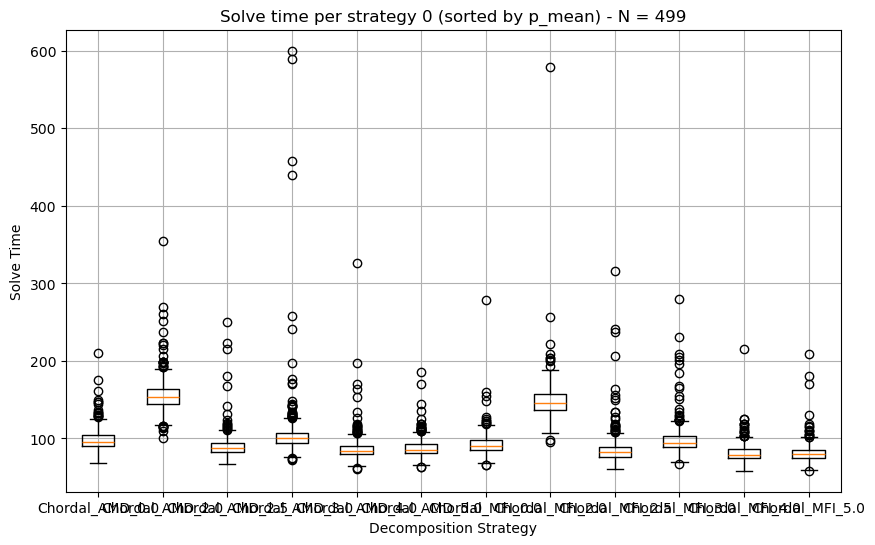

/tmp/ipykernel_1286935/554076288.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['chunk_name'] = chunk_name


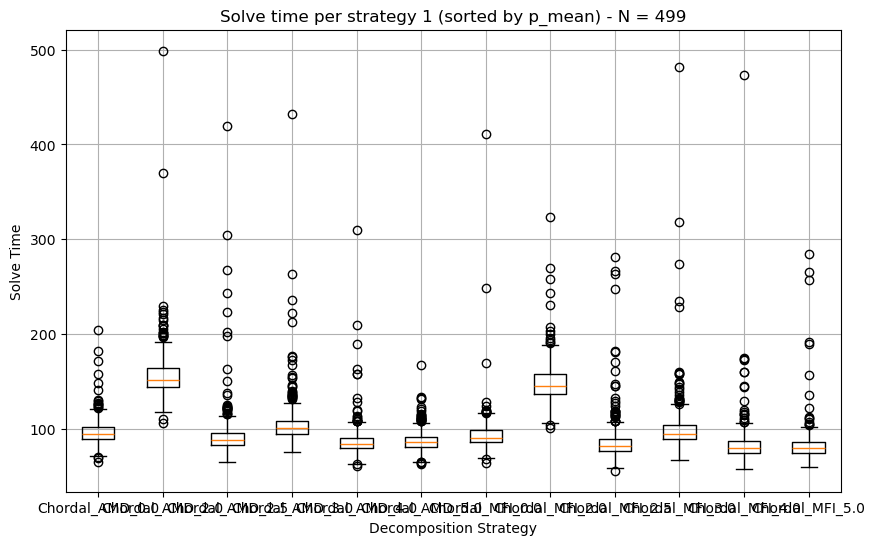

/tmp/ipykernel_1286935/554076288.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['chunk_name'] = chunk_name


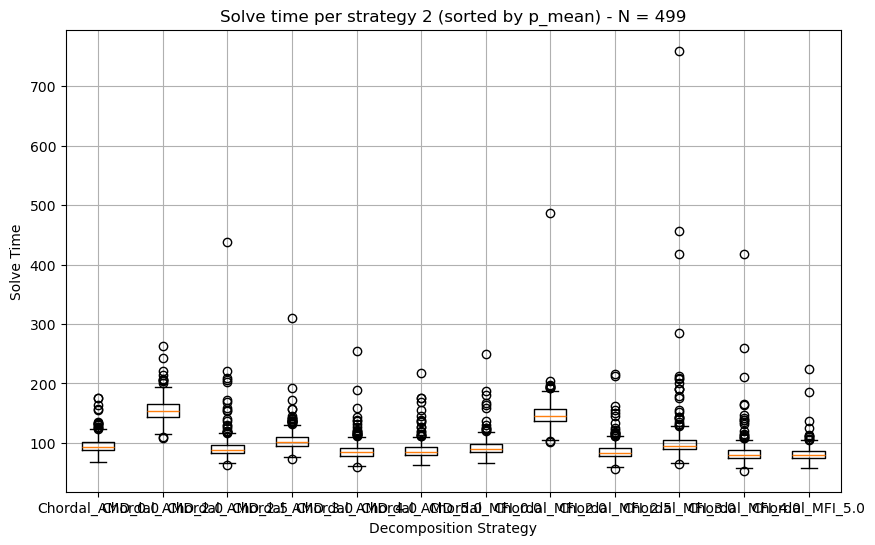

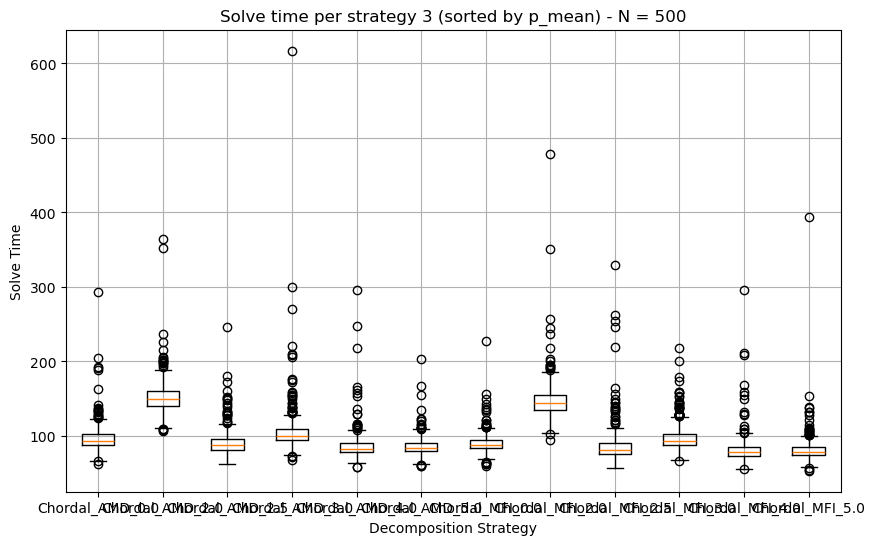

[                                                   case    p_mean     p_std  \
1789  pglib_opf_case2746wop_k_0.07_perturbation_3692...  0.100347  0.324760   
1660  pglib_opf_case2746wop_k_0.07_perturbation_3563...  0.099596  0.354906   
1757  pglib_opf_case2746wop_k_0.07_perturbation_3660...  0.099265  0.309576   
1722  pglib_opf_case2746wop_k_0.07_perturbation_3625...  0.099217  0.302683   
1959  pglib_opf_case2746wop_k_0.07_perturbation_3862...  0.098896  0.301873   
...                                                 ...       ...       ...   
196   pglib_opf_case2746wop_k_0.03_perturbation_1697...  0.095614  0.233558   
1131  pglib_opf_case2746wop_k_0.05_perturbation_2833...  0.095611  0.227786   
951   pglib_opf_case2746wop_k_0.05_perturbation_2653...  0.095611  0.240434   
769   pglib_opf_case2746wop_k_0.03_perturbation_2270...  0.095609  0.234211   
1737  pglib_opf_case2746wop_k_0.07_perturbation_3640...  0.095606  0.243490   

      p_min      p_max    q_mean     q_std  q_min 

In [3]:
import matplotlib.pyplot as plt
def boxplot(df, number, stat):
    """
    df : pd.DataFrame with columns Chordal_AMD_true, Chordal_AMD_false, Chordal_MFI_true, Chordal_MFI_false and profile
    number: int, the number of the plot
    
    For each column get the all the values and plot all the values in a boxplot where every strategy is a different box.
    Title of the Plot should be the number of the plot and the number of profiles in the df and written as "Solve time per strategy {number} (sorted by {stat} ) - N = {len(df)}"
    """
    #Strategies are the columns of the df that start with "Chordal_"
    strategies = [c for c in df.columns if c.startswith("Chordal_")]

    # Prepare data for boxplot
    data = [df[strategy].dropna() for strategy in strategies]
    
    # Create the boxplot
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=strategies)
    plt.title(f"Solve time per strategy {number} (sorted by {stat}) - N = {len(df)}")
    plt.ylabel('Solve Time')
    plt.xlabel('Decomposition Strategy')
    plt.grid(True)
    plt.show()

def sort_by_plot(df, sort_by, number_of_plots):
    """ df: pd.DataFrame with the the statistics of each profile
        sort_by: str, the column to sort by
        number_of_plots: int, the number of subplots in the subplots
        
        The functions splits the df in number_of_plots, based on the sort_by column
        Then, each subdataset is named by its order in the sort_by column
        Then we boxplot the SolveTime per decomp strategy for each subdataset"""
        
    # Sort the DataFrame by the specified column
    sorted_df = df.sort_values(by=sort_by, ascending=False)
    print(sorted_df.head())
    
    # Split the DataFrame into chunks for plotting
    chunk_size = len(sorted_df) // number_of_plots
    chunks = [sorted_df.iloc[i:i + chunk_size] for i in range(0, len(sorted_df), chunk_size)]
    
    # If the last chunk is smaller than chunk_size, we merge it with the previous one
    if len(chunks) > number_of_plots:
        chunks[-2] = pd.concat([chunks[-2], chunks[-1]], ignore_index=True)
        chunks = chunks[:-1]
    
    # Assign names to each chunk based on the sort_by column
    for i, chunk in enumerate(chunks):
        chunk_name = f"{sort_by}_{i+1}"
        chunk['chunk_name'] = chunk_name
        boxplot(chunk, i, sort_by)
        
        
    #Create the boxplots for each chunk
        
        
    return chunks
    
    
print(sort_by_plot(stats, 'p_mean', 4))

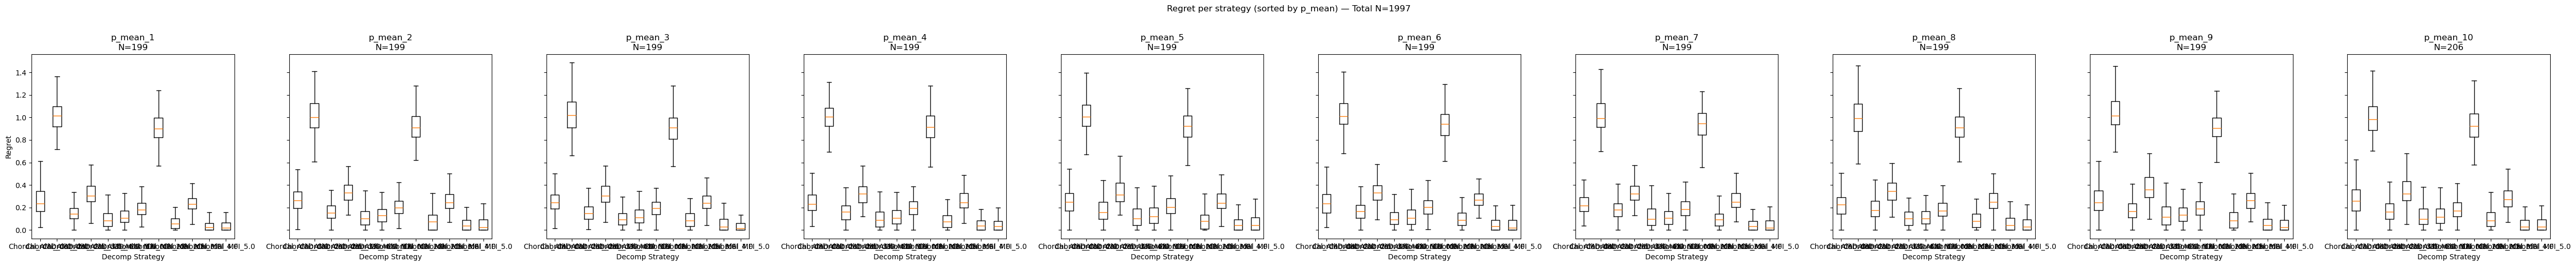

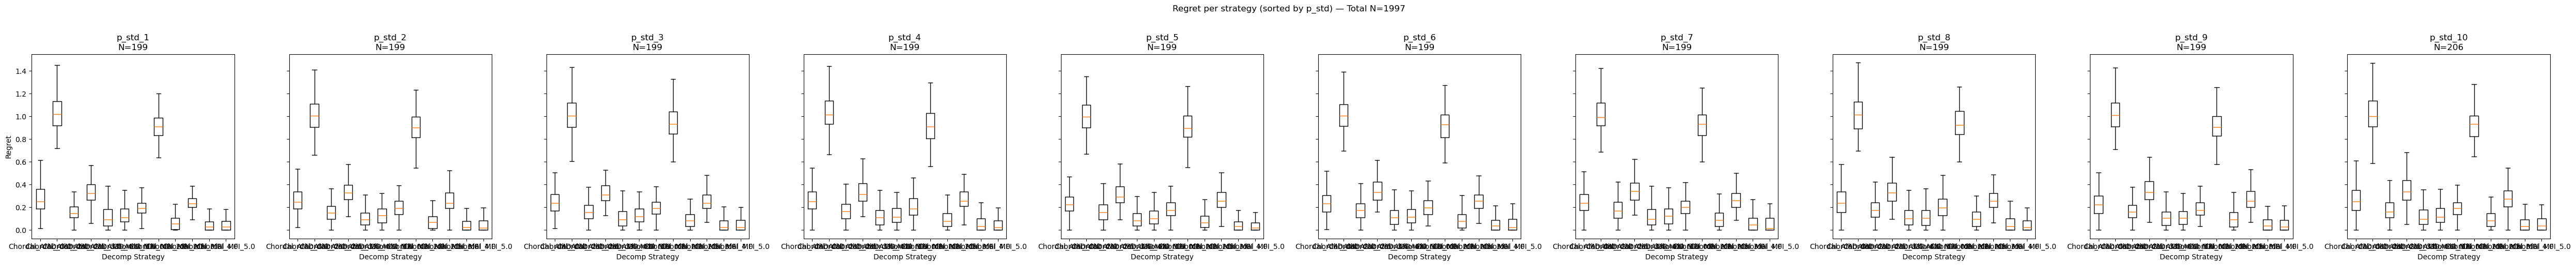

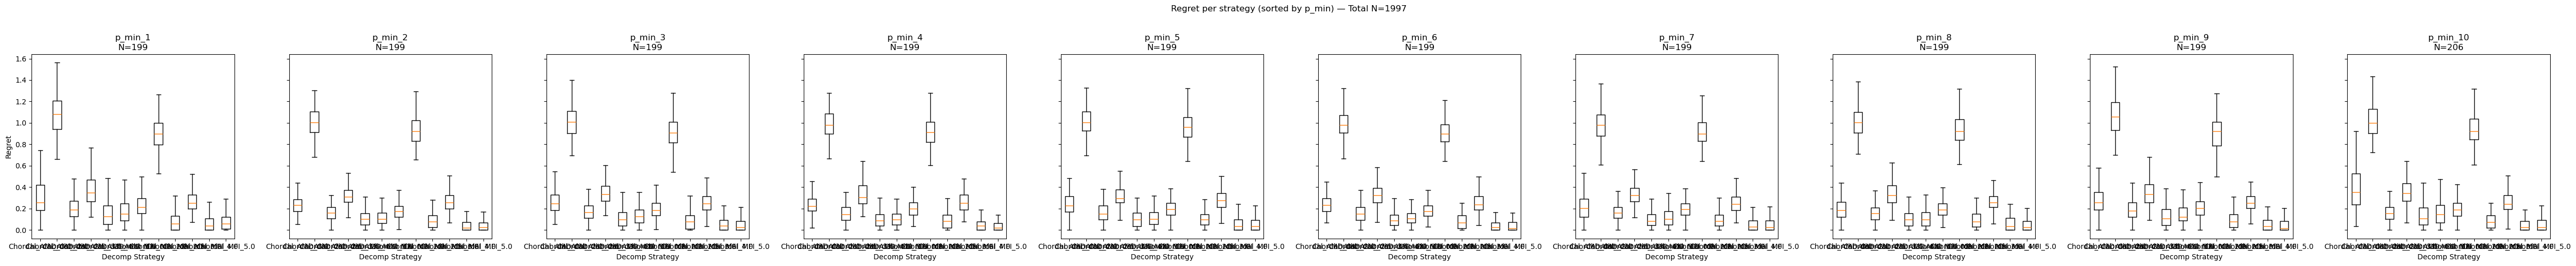

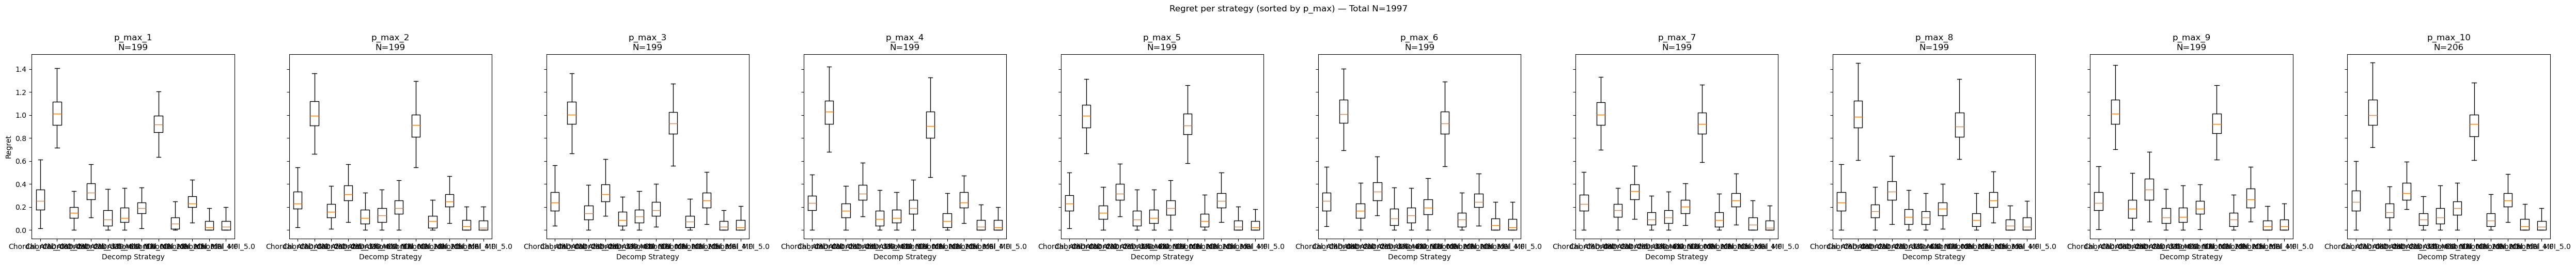

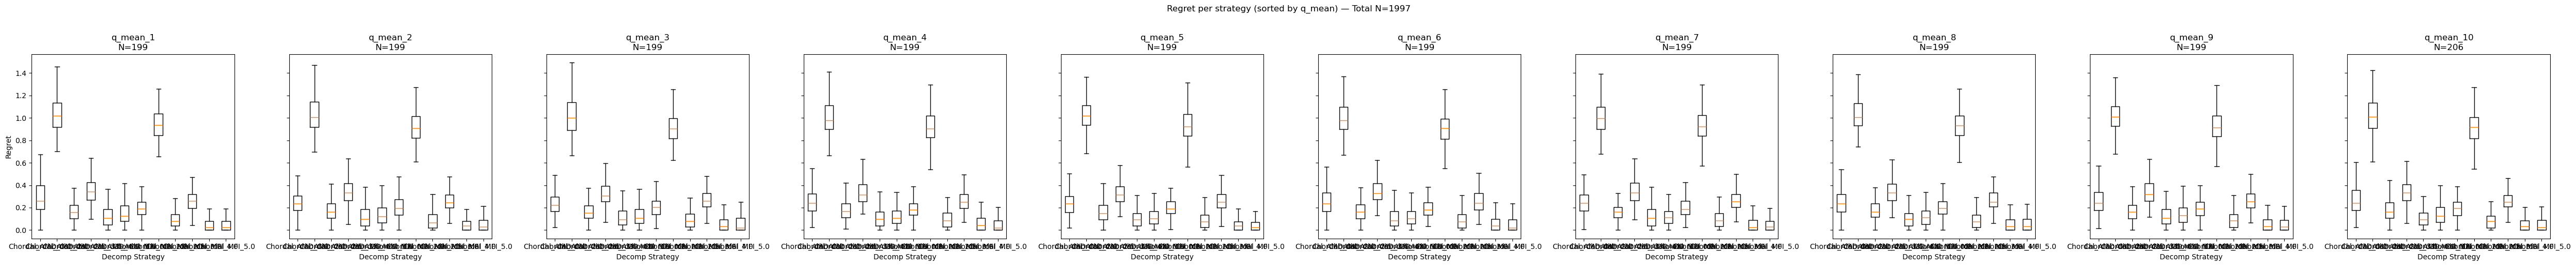

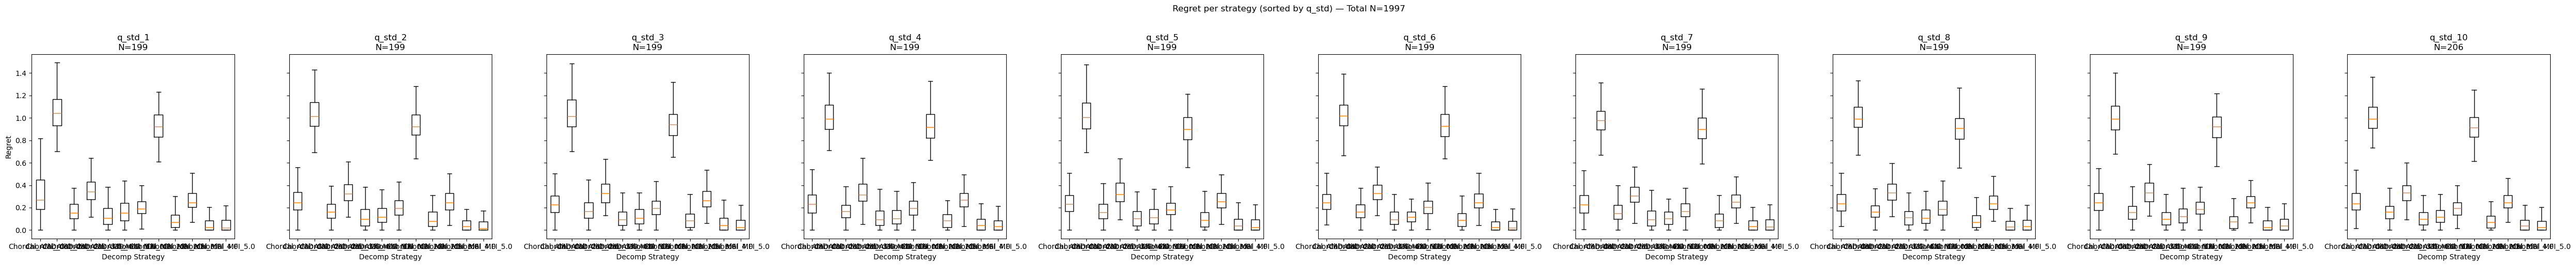

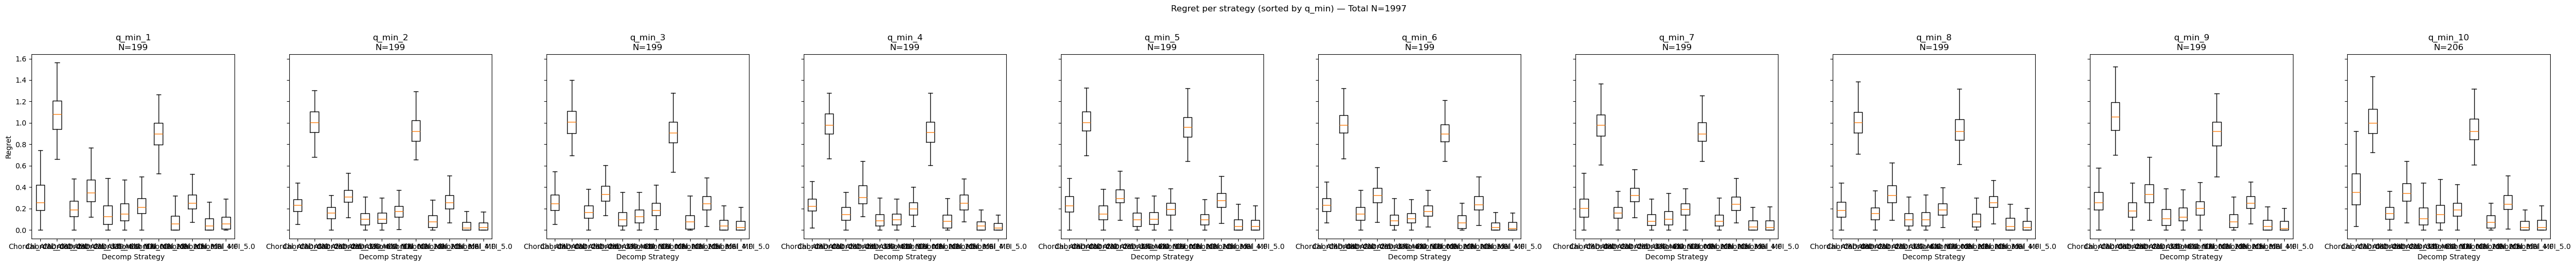

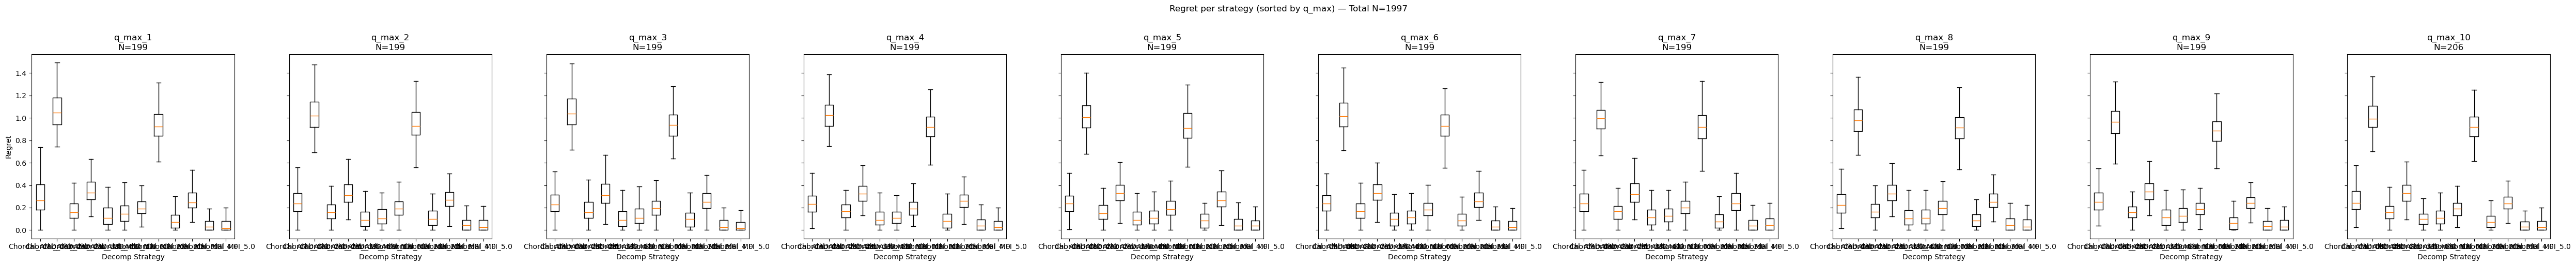

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

def compute_regret(df: pd.DataFrame,
                   profile_col: str = "profile") -> pd.DataFrame:
    """
    Given a DataFrame with one row per profile and columns
    like 'AMD_true', 'AMD_false', 'MFI_true', 'MFI_false' (plus any
    other cols), returns a new DataFrame where those four strategy
    columns have been replaced by their regret:

        regret_s = (t_solve_s − t_best) / t_best

    where t_best = min_s(t_solve_s) for that row.

    The profile column (and any other cols) are left untouched.
    """
    # 1) copy to avoid mutating the original
    df_reg = df.copy()

    # 2) detect the four strategy cols (exactly those ending in _true or _false)
    strat_cols = [c for c in df.columns if c.startswith("Chordal_")]


    # 3) compute the best solve‐time per row
    best = df_reg[strat_cols].min(axis=1)

    # 4) replace each strategy col by its regret
    df_reg[strat_cols] = (
        df_reg[strat_cols]
        .sub(best, axis=0)
        .div(best, axis=0)
    )

    return df_reg

def sort_by_plot_subplots(df: pd.DataFrame,
                          sort_by: str,
                          number_of_plots: int, name:str = "Solve_time"):
    """
    Splits `df` into `number_of_plots` chunks sorted by `sort_by`, then
    makes one figure with `number_of_plots` side-by-side boxplots of 
    solve times per decomposition strategy.
    """
    # 1) Sort once
    sorted_df = df.sort_values(by=sort_by, ascending=False)
    N = len(sorted_df)

    # 2) Split into chunks
    chunk_size = N // number_of_plots
    chunks = []
    for i in range(number_of_plots):
        start = i * chunk_size
        end   = (i + 1) * chunk_size if i < number_of_plots - 1 else N
        chunks.append(sorted_df.iloc[start:end])
    
    # 3) Detect your four strategy columns dynamically:
    strategies = [c for c in df.columns if c.startswith("Chordal_")]

    strategies = sorted(strategies)  # alphabetical: ['AMD_false','AMD_true',…]
    labels     = strategies[:]       # same order for labels

    # 4) Make subplots
    fig, axes = plt.subplots(
        nrows=1,
        ncols=number_of_plots,
        figsize=(5 * number_of_plots, 5),
        sharey=True
    )
    if number_of_plots == 1:
        axes = [axes]

    # 5) Fill each
    for i, (ax, chunk) in enumerate(zip(axes, chunks)):
        data = [chunk[strat].dropna() for strat in strategies]
        ax.boxplot(data, labels=labels, showfliers=False)
        ax.set_title(f"{sort_by}_{i+1}\nN={len(chunk)}")
        ax.set_xlabel("Decomp Strategy")
        if i == 0:
            ax.set_ylabel(name)

    # 6) Super‐title & layout
    fig.suptitle(f"{name} per strategy (sorted by {sort_by}) — Total N={N}",
                 y=1.02)
    plt.tight_layout()
    plt.show()

    return chunks

# sort_by_plot_subplots(stats, 'p_mean', 4)
# for s in ["p_mean", "p_std", "p_min", "p_max",
#           "q_mean", "q_std", "q_min", "q_max"]:
#     sort_by_plot_subplots(stats, s, 4)
# compute the solve time as regret   
df_regret = compute_regret(stats)

for s in ["p_mean", "p_std", "p_min", "p_max",
          "q_mean", "q_std", "q_min", "q_max"]:
    sort_by_plot_subplots(df_regret, s, 10, "Regret")


In [5]:
import pandas as pd

def summarize_best_strategies(df: pd.DataFrame,
                              sort_by: str,
                              number_of_chunks: int):
    """
    Splits `df` into `number_of_chunks` chunks sorted by `sort_by`, then for each chunk:
      - finds which strategy column has the minimum value on each row
      - counts how many times each strategy is best
      - computes the proportion of wins per strategy

    Returns
    -------
    counts_df : DataFrame, shape (number_of_chunks, S)
        counts_df.loc[chunk, strat] = number of profiles in `chunk` where `strat` was best
    prop_df   : DataFrame, same shape
        prop_df = counts_df / chunk_size  (float)
    """
    # 1) Sort & split
    sorted_df = df.sort_values(by=sort_by, ascending=False)
    N = len(sorted_df)
    chunk_size = N // number_of_chunks
    chunks = [
        sorted_df.iloc[i*chunk_size : (i+1)*chunk_size if i < number_of_chunks-1 else N]
        for i in range(number_of_chunks)
    ]

    # 2) Identify your strategy columns
    strat_cols = [c for c in df.columns if c.startswith("Chordal_")]


    count_rows = []
    prop_rows  = []
    for i, chunk in enumerate(chunks, start=1):
        # which strategy is best on each row?
        best = chunk[strat_cols].idxmin(axis=1)
        counts = best.value_counts().to_dict()
        total = len(chunk)

        # build row dicts
        count_row = { strat: counts.get(strat, 0) for strat in strat_cols }
        prop_row  = { strat: count_row[strat] / total for strat in strat_cols }

        # label by chunk name
        chunk_name = f"{sort_by}_{i}"
        count_row["chunk"] = chunk_name
        prop_row["chunk"]  = chunk_name

        count_rows.append(count_row)
        prop_rows.append(prop_row)

    # 3) Build DataFrames
    counts_df = pd.DataFrame(count_rows).set_index("chunk")[strat_cols]
    prop_df   = pd.DataFrame(prop_rows).set_index("chunk")[strat_cols]

    return counts_df, prop_df
counts_df, prop_df = summarize_best_strategies(df_regret, 'p_mean', 4)
print("Counts of best strategies per chunk:\n", counts_df)
print("Proportions of best strategies per chunk:\n", prop_df)
variance_dict = {}
for s in ["p_mean", "p_std", "p_min", "p_max",
          "q_mean", "q_std", "q_min", "q_max"]:
    counts_df, prop_df = summarize_best_strategies(df_regret, s, 10)
    print(f"Counts of best strategies per chunk for {s}:\n", counts_df)
    print(f"Proportions of best strategies per chunk for {s}:\n", prop_df)
    var_series = prop_df.var(axis=0)
    
    variance_dict[s] = var_series

# Build a DataFrame out of it
var_df = pd.DataFrame(variance_dict).T
var_df.index.name = "sort_key"
#Make sure the values are floats
var_df = var_df.astype(float)

# Also record which strategy had the highest variance for each sort_key
var_df["top_strategy"]   = var_df.idxmax(axis=1)
var_df["max_variance"] = var_df.max(axis=1, numeric_only=True)

# Sort descending by max_variance to surface the most “interesting” stats
var_df = var_df.sort_values("max_variance", ascending=False)

print(var_df)

Counts of best strategies per chunk:
           Chordal_AMD_0.0  Chordal_AMD_2.0  Chordal_AMD_2.5  Chordal_AMD_3.0  \
chunk                                                                          
p_mean_1                0                0                7                0   
p_mean_2                1                0                8                0   
p_mean_3                1                0                8                0   
p_mean_4                5                0                3                1   

          Chordal_AMD_4.0  Chordal_AMD_5.0  Chordal_MFI_0.0  Chordal_MFI_2.0  \
chunk                                                                          
p_mean_1               34               20                0                0   
p_mean_2               50               38                3                0   
p_mean_3               41               35                2                0   
p_mean_4               49               31                2                0   



In [6]:



df_2
print(df_2.head())
strat_cols = [c for c in df_2.columns if c.startswith("Chordal_")]
df_regret = df_2[strat_cols + ["case"]]

df_regret = compute_regret(df_regret)

print(df_regret.head())

df_regret

   pd_bus_306  qd_bus_306  pd_bus_1886  qd_bus_1886  pd_bus_1  qd_bus_1  \
0    0.076174    0.036590     0.051960     0.010170  0.021602  0.345318   
1    0.057682    0.044165     0.069578     0.008016  0.022868  0.370595   
2    0.054601    0.034653     0.047780     0.009802  0.020929  0.287435   
3    0.086365    0.039667     0.057291     0.010267  0.022208  0.353787   
4    0.087760    0.034225     0.045919     0.010700  0.015567  0.442957   

   pd_bus_519  qd_bus_519  pd_bus_788  qd_bus_788  ...  Chordal_AMD_2.5  \
0    0.036639    0.010596    0.007878         0.0  ...       112.729930   
1    0.043763    0.018687    0.006134         0.0  ...        98.443667   
2    0.045584    0.020037    0.007408         0.0  ...        99.570549   
3    0.046455    0.015572    0.006731         0.0  ...        98.462890   
4    0.042833    0.014104    0.007654         0.0  ...        98.801841   

   Chordal_AMD_3.0  Chordal_AMD_4.0  Chordal_AMD_5.0  Chordal_MFI_0.0  \
0       119.479034       

,Chordal_AMD_0.0,Chordal_AMD_2.0,Chordal_AMD_2.5,Chordal_AMD_3.0,Chordal_AMD_4.0,Chordal_AMD_5.0,Chordal_MFI_0.0,Chordal_MFI_2.0,Chordal_MFI_2.5,Chordal_MFI_3.0,Chordal_MFI_4.0,Chordal_MFI_5.0,case
0,0.083664,0.876212,0.172440,0.242634,0.178942,0.158980,0.170179,0.601493,0.003437,0.125737,0.000000,0.030198,pglib_opf_case2746wop_k_0.03_perturbation_1501...
1,0.237382,0.933770,0.168473,0.287467,0.187385,0.029711,0.157323,0.772680,0.057118,0.165345,0.000000,0.122527,pglib_opf_case2746wop_k_0.03_perturbation_1502...
2,0.292841,1.459872,0.191171,0.345458,0.161908,0.185418,0.394550,0.722412,0.042806,0.177934,0.000000,0.178864,pglib_opf_case2746wop_k_0.03_perturbation_1503...
3,0.199295,1.111243,0.142441,0.203838,0.062365,0.095009,0.262502,0.793343,0.000000,0.198249,0.033229,0.275246,pglib_opf_case2746wop_k_0.03_perturbation_1504...
4,0.042367,0.923281,0.117028,0.251888,0.166231,0.178082,0.129403,0.527266,0.000000,0.106688,0.026097,0.163452,pglib_opf_case2746wop_k_0.03_perturbation_1505...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,1.215052,1.399787,0.646660,1.103136,0.456862,0.374132,0.261620,0.723282,0.000000,0.321134,0.218521,0.111685,pglib_opf_case2746wop_k_0.07_perturbation_3895...
1993,0.486572,0.991196,0.178687,0.381445,0.173310,0.244990,0.190568,0.792758,0.052365,0.204567,0.000000,0.030721,pglib_opf_case2746wop_k_0.07_perturbation_3896...
1994,0.532764,0.916201,0.259387,0.463802,0.342217,0.413511,0.141319,0.774238,0.032997,0.202837,0.033639,0.000000,pglib_opf_case2746wop_k_0.07_perturbation_3897...
1995,0.815045,0.875758,0.139376,0.463264,0.435243,0.594104,0.221541,0.733229,0.000000,0.250862,0.179551,0.113578,pglib_opf_case2746wop_k_0.07_perturbation_3898...


In [7]:
#Print all columns starting by "Chordal_" in df_2
print(df_2.columns)
print(df_2.columns[df_2.columns.str.startswith("Chordal_")])
#df_2.drop(columns=["Chordal_MFI_false", "Chordal_AMD_true", "Chordal_MFI_true", "Chordal_AMD_false"], inplace=True)

#Make sure the rows are ordered the same by the case column in df_2 and df_regret
#let X and Y in the same oeder
df_2 = df_2.set_index("case").reindex(df_regret["case"]).reset_index()
print(df_2.head())
print(df_regret.head())

Index(['pd_bus_306', 'qd_bus_306', 'pd_bus_1886', 'qd_bus_1886', 'pd_bus_1',
       'qd_bus_1', 'pd_bus_519', 'qd_bus_519', 'pd_bus_788', 'qd_bus_788',
       ...
       'Chordal_AMD_2.5', 'Chordal_AMD_3.0', 'Chordal_AMD_4.0',
       'Chordal_AMD_5.0', 'Chordal_MFI_0.0', 'Chordal_MFI_2.0',
       'Chordal_MFI_2.5', 'Chordal_MFI_3.0', 'Chordal_MFI_4.0',
       'Chordal_MFI_5.0'],
      dtype='object', length=4007)
Index(['Chordal_AMD_0.0', 'Chordal_AMD_2.0', 'Chordal_AMD_2.5',
       'Chordal_AMD_3.0', 'Chordal_AMD_4.0', 'Chordal_AMD_5.0',
       'Chordal_MFI_0.0', 'Chordal_MFI_2.0', 'Chordal_MFI_2.5',
       'Chordal_MFI_3.0', 'Chordal_MFI_4.0', 'Chordal_MFI_5.0'],
      dtype='object')
                                                case  pd_bus_306  qd_bus_306  \
0  pglib_opf_case2746wop_k_0.03_perturbation_1501...    0.076174    0.036590   
1  pglib_opf_case2746wop_k_0.03_perturbation_1502...    0.057682    0.044165   
2  pglib_opf_case2746wop_k_0.03_perturbation_1503...    0.054601

In [8]:
#Create X Matrix and a regret vector Y with features from df_2 (except case column)
X = df_2.drop(columns=["case"]).values
#case disappears as the index
Y = df_regret.set_index("case").values
print(X.shape)
print(Y.shape)

#Make a PCA on the X matrix
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)
print("PCA shape:", X_pca.shape)
X = X_pca

#Save X_PCA and Y_A as csv
output_file_X = "//home/goatoine/Documents/Lanyue/data/feature/XGboost/X_PCA.csv"
output_file_Y = "//home/goatoine/Documents/Lanyue/data/feature/XGboost/Y_A.csv"

pd.DataFrame(X).to_csv(output_file_X, index=False)
pd.DataFrame(Y).to_csv(output_file_Y, index=False)

print(f"X_PCA saved to {output_file_X}")
print(f"Y_A saved to {output_file_Y}")

(1997, 4006)
(1997, 12)
PCA shape: (1997, 100)
X_PCA saved to //home/goatoine/Documents/Lanyue/data/feature/XGboost/X_PCA.csv
Y_A saved to //home/goatoine/Documents/Lanyue/data/feature/XGboost/Y_A.csv


In [9]:
import pandas as pd
import numpy as np
X = pd.read_csv("//home/goatoine/Documents/Lanyue/data/feature/XGboost/X_PCA.csv").values
Y = pd.read_csv("//home/goatoine/Documents/Lanyue/data/feature/XGboost/Y_A.csv").values

print("X shape:", X.shape)
print("Y shape:", Y.shape)

import numpy as np
from sklearn.model_selection import train_test_split

# 1) build an array of row‐indices
idx = np.arange(X.shape[0])       # [0, 1, 2, …, n_samples-1]

# 2) split those indices
# why needn't validation set?
train_idx, test_idx = train_test_split(
    idx,
    test_size=0.2,
    random_state=42
)

# 3) now test_idx gives you the original‐matrix row numbers in the test set
print("Original rows in test set:", test_idx)

# 4) if you want the actual values:
X_test_values  = X[test_idx]
Y_test_values  = Y[test_idx]

# 5) or, if you still have your DataFrame
#    (assuming df_2 and df_regret have the same row order)
df2_test   = df_2.iloc[test_idx]
reg_test   = df_regret.iloc[test_idx]

print(df2_test["case"].unique())


print(df2_test.shape)

X shape: (1997, 100)
Y shape: (1997, 12)
Original rows in test set: [ 256  352  298  581 1286 1280  420 1740   65 1609   56 1293 1117  582
 1231  316  744  128 1440 1510 1676  923  479 1956  593   99  416  962
  307   29  599 1971  570  905 1423 1754  845 1287  808 1563  124 1604
  527  984 1290  251 1424  887   70  482 1531 1541  886  210  519  849
  670  233 1181  651 1450 1657  453  289 1828 1844 1334 1688  111 1272
  344 1606 1392 1053  757 1229 1480 1198  367  785   69 1481 1630 1753
 1177 1489  427 1027  710  584  715  514 1273  792 1343 1233 1815  368
 1719 1928 1811 1490 1192 1075  237 1924  618  254  231  382 1283  680
 1040  433  383 1170 1316 1800  730 1728  745  342  211 1310  212 1494
  438  914  994 1453 1884 1004 1807  247 1625 1278  411 1134 1146  576
 1431  305 1680 1452  865  759  394 1347 1269  120 1553  538  807 1270
  306  135  552  583  485  422 1686  832  109 1412 1468  239  904  507
 1693 1323 1473  705  704  771 1726 1816 1642 1497 1265 1029  943 1463
  780 137

In [ ]:
print

In [10]:
#这个直接预测类别是不起作用的，因为训练预测集的类别不一样
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.preprocessing import LabelEncoder
#1) for each column in Y, create a classification label
classes = Y.shape[1]
#Creat a matrix y where for each 

# 1) Build hard labels for stratification
y = np.argmin(Y, axis=1)


# If you have classes with <5 examples, reduce n_splits to avoid that warning:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

fold_regrets = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
    Xtr, Xte = X[train_idx], X[test_idx]
    ytr_raw, yte_raw = y[train_idx], y[test_idx]
    le = LabelEncoder()
    ytr = le.fit_transform(ytr_raw)
    yte = le.transform(yte_raw) 
    clf = XGBClassifier(
        objective='multi:softprob',
        num_class=Y.shape[1],
        tree_method='hist',   # fast histogram algorithm
        device='cuda',        # run on GPU
        eval_metric='mlogloss',
        n_jobs=-1             # still parallel on CPU for multiclass logic
    )
    
    #À supprimer si besoin 
    print("Analyse des classes:")
    print(f"Classes uniques dans ytr: {np.unique(ytr)}")
    print(f"Distribution des classes:")
    unique, counts = np.unique(ytr_raw, return_counts=True)
    for classe, count in zip(unique, counts):
        print(f"  Classe {classe}: {count} échantillons")

    # Vérifier s'il y a des NaN
    print(f"Valeurs NaN dans ytr: {np.isnan(ytr_raw).sum()}")
    print(f"Type de données: {ytr_raw.dtype}")
    clf.fit(Xtr, ytr)
    preds_encoded = clf.predict(Xte)
    preds = le.inverse_transform(preds_encoded)  # 映射回原始类别编号
    # compute *actual* regret on the held-out fold
    fold_regrets.append(
        np.mean([Y[test_idx[i], preds[i]] for i in range(len(preds))])
    )

    print(f"Fold {fold} regret: {fold_regrets[-1]:.5f}")

print("CV mean regret:", np.mean(fold_regrets))



/home/goatoine/anaconda3/envs/OPF_ML/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Analyse des classes:
Classes uniques dans ytr: [0 1 2 3 4 5 6 7 8 9]
Distribution des classes:
  Classe 0: 5 échantillons
  Classe 2: 17 échantillons
  Classe 3: 1 échantillons
  Classe 4: 116 échantillons
  Classe 5: 82 échantillons
  Classe 6: 5 échantillons
  Classe 8: 216 échantillons
  Classe 9: 1 échantillons
  Classe 10: 424 échantillons
  Classe 11: 464 échantillons
Valeurs NaN dans ytr: 0
Type de données: int64


/home/goatoine/anaconda3/envs/OPF_ML/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:51:15] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Fold 1 regret: 0.01286


ValueError: y contains previously unseen labels: [3]

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
import xgboost
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import importlib
import MXGB_ES  # 假设你文件名是 MXGB_ES.py

importlib.reload(MXGB_ES)

from MXGB_ES import MultiTargetXGBRegressorWithEarlyStop
import sys
print("当前解释器路径：", sys.executable)

import xgboost
print("xgboost 路径：", xgboost.__file__)
print(XGBRegressor.__module__)
print("当前 xgboost 版本：", xgboost.__version__)
X_test = X[test_idx]
Y_test = Y[test_idx]
X_train = X[train_idx]
Y_train = Y[train_idx]
# 拆分训练集 -> 验证集
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42
)

import gc
import torch  # si vous utilisez PyTorch


if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()
# 初始化并训练
mt_xgb = MultiTargetXGBRegressorWithEarlyStop()
mt_xgb.fit(X_train, Y_train, X_val, Y_val, verbose=True)
# 预测
Y_pred = mt_xgb.predict(X_test)
preds = mt_xgb.predict_argmin(X_test)

for model in mt_xgb.get_models():
    mt_xgb.plot_learning_curves(model)
    
mean_regret = np.mean([ Y_test[j, preds[j]] for j in range(len(preds)) ])
print(Y_test)
print("Mean test regret:", mean_regret)
print("Mean test regret per class:", Y_test.mean(axis=0))
cm = confusion_matrix(np.argmin(Y_test, axis=1), preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix for XGBRegressor")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


当前解释器路径： /home/goatoine/anaconda3/envs/OPF_ML/bin/python
xgboost 路径： /home/goatoine/anaconda3/envs/OPF_ML/lib/python3.9/site-packages/xgboost/__init__.py
xgboost.sklearn
当前 xgboost 版本： 2.1.4
xgboost.sklearn
[0]	validation_0-rmse:0.17892	validation_1-rmse:0.15501
[1]	validation_0-rmse:0.17266	validation_1-rmse:0.14970
[2]	validation_0-rmse:0.16672	validation_1-rmse:0.14474
[3]	validation_0-rmse:0.16102	validation_1-rmse:0.14019
[4]	validation_0-rmse:0.15568	validation_1-rmse:0.13653
[5]	validation_0-rmse:0.15061	validation_1-rmse:0.13306
[6]	validation_0-rmse:0.14566	validation_1-rmse:0.12926
[7]	validation_0-rmse:0.14104	validation_1-rmse:0.12602
[8]	validation_0-rmse:0.13665	validation_1-rmse:0.12334
[9]	validation_0-rmse:0.13237	validation_1-rmse:0.12042
[10]	validation_0-rmse:0.12830	validation_1-rmse:0.11801
[11]	validation_0-rmse:0.12441	validation_1-rmse:0.11542
[12]	validation_0-rmse:0.12070	validation_1-rmse:0.11306
[13]	validation_0-rmse:0.11723	validation_1-rmse:0.11047
[14]	

In [24]:
#Recuperer les colonnes de df_2 qui commencent par "Chordal_"
chordal_cols = [c for c in df_2.columns if c.startswith("Chordal_")]
print("Chordal columns:", chordal_cols)
df_test = df2_test[chordal_cols]
df_test
#Rename the chordal columns to 0 - 11 in order to match Y
df_test.columns = [str(i) for i in range(len(df_test.columns))]

df_test 
#Create a column of min solve time for each row
df_test['min_solve_time'] = df_test.min(axis=1)

df_test


Chordal columns: ['Chordal_AMD_0.0', 'Chordal_AMD_2.0', 'Chordal_AMD_2.5', 'Chordal_AMD_3.0', 'Chordal_AMD_4.0', 'Chordal_AMD_5.0', 'Chordal_MFI_0.0', 'Chordal_MFI_2.0', 'Chordal_MFI_2.5', 'Chordal_MFI_3.0', 'Chordal_MFI_4.0', 'Chordal_MFI_5.0']


/tmp/ipykernel_1286935/2869779254.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['min_solve_time'] = df_test.min(axis=1)


,0,1,2,3,4,5,6,7,8,9,10,11,min_solve_time
256,97.001006,151.538586,88.342841,101.788414,86.439660,84.174266,84.756646,143.684168,89.932956,104.136003,88.618231,79.276734,79.276734
352,89.870543,150.293747,88.393645,94.392679,79.529133,80.496673,97.800970,147.767000,82.524891,103.925542,82.337070,75.780688,75.780688
298,89.434747,150.542902,89.872755,93.597486,74.323654,82.080533,97.104141,144.383196,74.320523,94.712251,73.563527,81.620062,73.563527
581,89.377535,140.701045,84.309035,90.367882,73.802877,82.450073,85.955026,139.063705,80.838700,93.372877,71.119217,72.321795,71.119217
1286,96.701449,147.597693,87.061394,98.514527,85.261993,86.532976,87.505088,125.596772,78.593772,91.216269,72.777271,81.998260,72.777271
...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,80.882809,130.637277,74.796292,92.167739,76.601285,80.107121,93.075527,138.988735,78.224834,87.790115,63.851026,70.080600,63.851026
1435,87.007596,133.368056,86.181278,93.272438,98.868266,78.287733,76.418568,125.298968,72.999191,85.938238,80.007272,83.062010,72.999191
261,84.973555,154.401921,83.648249,102.048060,80.720971,84.895495,97.273644,140.831560,78.380436,99.539072,78.598785,88.585872,78.380436
1303,84.713700,175.128650,92.810463,96.267877,77.610225,83.203715,88.968431,145.495191,82.873220,88.213495,73.288823,77.001962,73.288823


(666, 12)
(666, 100)
(666, 4007)
(666, 1)
Predicted best strategies: [10 10 10 10 10  5 10  5 11 10 10 11 11 11 10 10 11  5 11  5 11  5  8  8
  5  8 11  8 10 11 10 10 10 11  8 11 11 11 10 10  5  8 10 10 11 10 10 10
 11 10 10  8 10  8  8 10  8  5 10 11 11 11 10  8 11  8  8  5 10 10  8 11
 11 11 11 10 10 10 11 10 11 10 10 10  8 11 10 10 10 10 11 10 11 11 11  8
  8 10 10 10 10 10  8 11 10 11  8 11 11  4 11 11 11 11 11 10 11 10 11 11
 11 10  8 11  8 11 11 10 11 10 10  5 11 10 11 11 11 10 10 11 10 10 11 10
 11  8  8 11 10 10 10  5 11 10 11 10  5 11 11 11 11 11 10 11  8  8 10 11
  8 10 11 10  8 11 11 11 11 11 10 10 10 11  8 10 10  8 10 10 10 10  8 11
 10 10 10 11  8 10 10  5 10  5 11 10 11 10 11 11 11 11 11 11  8 11 11 11
 10 11  8 10 10 11 11 11 10  8 10 11  8  8 11 11 10  8  8 10 10 11 11 11
 11 11 11 10 11 11 11 11 11  8 10  8 10 10 10 11 10 11 11 10 11 11 11 11
 10 11  2 11 10 11  8  5 11 10  8  5 11 10 11 11 10 10  5 10 10  5  5 11
 11 10 11 10 10 11  8 10 10 10 10 11  5  8 11 11 11 10 

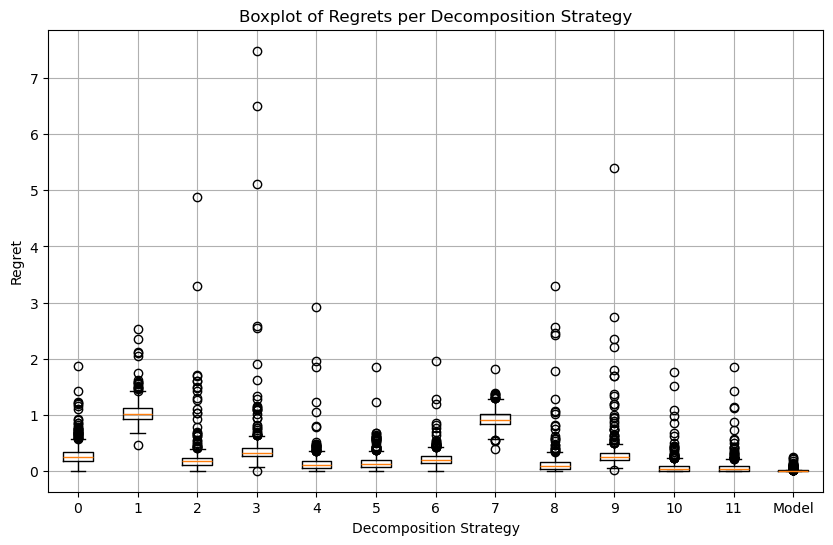

Y_test_copy head [[0.08366403 0.87621233 0.17244032 0.24263393 0.17894164 0.15897987
  0.17017873 0.60149271 0.00343688 0.12573676 0.         0.03019835
  0.        ]
 [0.2373821  0.93377027 0.16847324 0.287467   0.1873847  0.02971147
  0.15732314 0.77267981 0.05711753 0.16534489 0.         0.12252663
  0.        ]
 [0.04236702 0.9232812  0.11702848 0.25188766 0.1662313  0.17808228
  0.12940324 0.52726643 0.         0.10668845 0.02609724 0.16345167
  0.02609724]
 [0.03791317 0.71748775 0.17941606 0.45708005 0.         0.09573207
  0.08957054 0.54997885 0.05841069 0.17947424 0.0335842  0.01793422
  0.0335842 ]
 [0.09633327 0.82864439 0.24860419 0.47898439 0.06311311 0.
  0.15910949 0.92123316 0.22213862 0.37092629 0.07485791 0.05323932
  0.07485791]]
(666, 13)


In [25]:
Regret_preds = pd.DataFrame(Y_pred, columns=[f"decomp_{i}" for i in range(Y_pred.shape[1])])
print(Y_test.shape)
print(X_test.shape)
df2_test = df_2.iloc[test_idx]
print(df2_test.shape)
print(df2_test['case'].values.reshape(-1, 1).shape)
preds = np.argmin(Y_pred, axis=1)
print("Predicted best strategies:", preds)

Y_preds = [Y_test[j, preds[j]] for j in range(len(preds))]
print("Predicted regrets:", Y_preds)
Y_test_copy = Y_test.copy()  # Create a copy of Y_test to avoid modifying the original
#Add Y_preds as a last column of Y_test_copy
Y_test_copy = np.hstack((Y_test_copy, np.array(Y_preds).reshape(-1, 1)))
#plot the values of each column as boxplot (X axis = columns, Y axis = values)

#Rename the column by order to MFI_false, AMD_true, MFI_true, AMD_false, Model (in order)
plt.figure(figsize=(10, 6))
plt.boxplot(Y_test_copy, labels=[f"{i}" for i in range(Y_test_copy.shape[1]-1)] + ["Model"])
plt.title("Boxplot of Regrets per Decomposition Strategy")
plt.xlabel("Decomposition Strategy")
plt.ylabel("Regret")
plt.grid(True)
plt.show()
print("Y_test_copy head" , Y_test_copy[:5, :])

print(Y_test_copy.shape)



In [1]:
print("Actual regret of the model (head):", Y_test_copy[:5, -1])

#add the case column from df2_test to Y_test_copy
print(df2_test['case'].values.reshape(-1, 1).shape)
cases = np.hstack((df2_test['case'].values.reshape(-1, 1), Y_test_copy))

#Sort cases by the last column (the model's predicted regret)
cases_sorted = cases[cases[:, -1].argsort()]

#Only keep 1 out of 4 cases
cases_sorted = cases_sorted[::4]

cases_sorted

#Save the unique cases in sorted case to a csv file 
output_file_cases = "/home/goatoine/Documents/BaptisteZ/ML/scratch/Test_cases_sorted.csv"
cases_sorted_C = cases_sorted[:, 0]
pd.DataFrame(cases_sorted_C, columns=['case']).to_csv(output_file_cases, index=False)
print(f"Sorted cases saved to {output_file_cases}")

NameError: name 'Y_test_copy' is not defined

In [ ]:
print(Y_test_copy[:5, :])

ST = Y_test_copy.copy()
ST += 1

print("Y_test_copy after adding 1:\n", ST[:5, :])

#For each row, multiply all columns by the corresponding value in df_test['min_solve_time']
for i in range(ST.shape[0]):
    ST[i,:] *= df_test['min_solve_time'].iloc[i]

print("Y_test_copy after multiplying by min_solve_time:\n", ST[:5, :])

#Create a new column with min solve time for each row
ST = pd.DataFrame(ST, columns=[f"decomp_{i}" for i in range(ST.shape[1]-1)] + ["Model"])
ST['min_solve_time'] = df_test['min_solve_time'].values

# Make a boxplot of the values of the 4 last columns of ST with custom colors
plt.figure(figsize=(10, 6))
box = plt.boxplot(ST.iloc[:, -5:-1], patch_artist=True, labels=["MFI_4", "MFI_5", "MODEL", "MIN_ST"])

# Set custom colors for each box
colors = ['orange', 'orange', 'green', 'lightblue']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title("Boxplot of Solve Time per Decomposition Strategy")
plt.xlabel("Decomposition Strategy")
plt.ylabel("Solve Time")
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# assume ST has columns "MFI_5", "Model"
cols = ["MFI_5", "Model"]
other = {"MFI_5":"Model", "Model":"MFI_5"}
jitter_width = 0.3

# 1) compute the global min/max of ALL partner‐values
#    (since partner for "MFI_5" is "Model" and vice versa)
partner_min = min(ST["MFI_5"].min(), ST["Model"].min())
partner_max = max(ST["MFI_5"].max(), ST["Model"].max())
norm = Normalize(vmin=partner_min, vmax=partner_max)

fig, ax = plt.subplots(figsize=(10, 6))

# draw the boxplots    
box = ax.boxplot([ST[c] for c in cols],
                 patch_artist=True,
                 labels=cols,
                 widths=0.6)
for patch, color in zip(box['boxes'], ['orange','green']):
    patch.set_facecolor(color)

# collect outlier indices so we can link them later if desired
outliers = {}

# 2) plot each column’s outliers, *using the same* norm
for i, c in enumerate(cols, start=1):
    data = ST[c]
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr

    mask = (data < lower) | (data > upper)
    idx = ST.index[mask]
    outliers[c] = idx

    y = data[mask].values
    partner_vals = ST.loc[idx, other[c]].values

    # deterministic jitter based on partner column
    pmin, pmax = partner_min, partner_max
    normed = (partner_vals - pmin) / (pmax - pmin) if pmax>pmin else np.zeros_like(partner_vals)
    offsets = (normed - 0.5) * 2 * jitter_width
    x = i + offsets

    ax.scatter(x, y,
               c=partner_vals,
               cmap='viridis',
               norm=norm,            # ← here’s the key
               edgecolors='k',
               s=60,
               alpha=0.9,
               zorder=2,
               label=f"{c} outliers")

# 3) single shared colorbar
mappable = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
mappable.set_array([])  # dummy
cbar = fig.colorbar(mappable, ax=ax)
cbar.set_label("Partner column solve time")

ax.set_title("Boxplot of Solve Time per Decomposition Strategy")
ax.set_xlabel("Decomposition Strategy")
ax.set_ylabel("Solve Time")
ax.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# assume ST has columns "MFI_5", "Model", and "min_solve_time"
cols = ["MFI_5", "Model"]
other = {"MFI_5":"Model", "Model":"MFI_5"}
jitter_width = 0.3

# Pre‐compute mins/maxs for normalization
pmin = {c: ST[c].min() for c in cols}
pmax = {c: ST[c].max() for c in cols}

fig, ax = plt.subplots(figsize=(10, 6))

# 1) boxplots
box = ax.boxplot([ST[c] for c in cols],
                 patch_artist=True,
                 labels=cols,
                 widths=0.6)
for patch, color in zip(box['boxes'], ['orange','green']):
    patch.set_facecolor(color)

# 2) scatter outliers as before (you can keep your existing code here)
outliers = {}
for i, c in enumerate(cols, start=1):
    data = ST[c]
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr

    mask = (data < lower) | (data > upper)
    idx = ST.index[mask]
    outliers[c] = idx

    y = data[mask].values
    partner_vals = ST.loc[idx, other[c]].values

    # deterministic jitter
    norm = (partner_vals - pmin[other[c]]) / (pmax[other[c]] - pmin[other[c]]) \
           if pmax[other[c]]>pmin[other[c]] else np.zeros_like(partner_vals)
    offsets = (norm - 0.5) * 2 * jitter_width
    x = i + offsets

    ax.scatter(x, y,
               c=partner_vals,
               cmap='viridis',
               edgecolors='k',
               s=60,
               alpha=0.9,
               zorder=2)

# 3) only lines for outliers *above* in Model
# compute Model’s “above” threshold
model_data = ST["Model"]
q1, q3 = np.percentile(model_data, [25, 75])
iqr = q3 - q1
_, upper = q1 - 1.5*iqr, q3 + 1.5*iqr

# indices where Model > upper
idxs_above_model = ST.index[model_data > upper]

for j in idxs_above_model:
    # point on MFI_5 side
    y1 = ST.at[j, "MFI_5"]
    val1 = ST.at[j, "Model"]        # partner = Model
    norm1 = (val1 - pmin["Model"]) / (pmax["Model"] - pmin["Model"])
    x1 = 1 + (norm1 - 0.5)*2*jitter_width

    # point on Model side
    y2 = ST.at[j, "Model"]
    val2 = ST.at[j, "MFI_5"]        # partner = MFI_5
    norm2 = (val2 - pmin["MFI_5"]) / (pmax["MFI_5"] - pmin["MFI_5"])
    x2 = 2 + (norm2 - 0.5)*2*jitter_width

    ax.plot([x1, x2], [y1, y2],
            color='gray',
            linewidth=0.8,
            alpha=0.7,
            zorder=1)

# 4) colorbar & labels
mappable = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(pmin.values()),
                                                     vmax=max(pmax.values())),
                                  cmap='viridis')
mappable.set_array([])
cbar = fig.colorbar(mappable, ax=ax)
cbar.set_label("Partner column solve time")

ax.set_title("Boxplot of Solve Time per Decomposition Strategy")
ax.set_xlabel("Decomposition Strategy")
ax.set_ylabel("Solve Time")
ax.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [ ]:
#For each column in Y_test_copy, only keep the 10th highest values
lengths = Y_test_copy.shape[1]
print("Shape of Y_test_copy:", Y_test_copy.shape)
Quartile = round(0.1 * Y_test_copy.shape[0])  # 10% of the number of rows
Y_test_copy = np.array([np.sort(col)[-Quartile:] for col in Y_test_copy.T]).T
# Convert back to DataFrame for better visualization
Y_test_copy_df = pd.DataFrame(Y_test_copy, columns=[f"{i}" for i in range(Y_test_copy.shape[1]-1)] + ["Model"])
print(Y_test_copy_df)    
# Plot the boxplot again with the reduced values
plt.figure(figsize=(10, 6))
plt.boxplot(Y_test_copy_df, labels=[f"{i}" for i in range(Y_test_copy.shape[1]-1)] + ["Model"])
plt.title(f"Boxplot of {Quartile} highest Regrets per Decomposition Strategy")
plt.xlabel("Decomposition Strategy")
plt.ylabel("Regret")
plt.grid(True)
plt.show()  

#Violin exact plots
plt.figure(figsize=(10, 6))
sns.violinplot(data=Y_test_copy_df, inner="quartile")
plt.title(f"Violin Plot of {Quartile} highest Regrets per Decomposition Strategy")
plt.xlabel("Decomposition Strategy")
plt.ylabel("Regret")
plt.grid(True)
plt.show()

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# 2) Train one XGBRegressor per output, storing evals_result
n_classes = Y_train.shape[1]
models = []
evals_results = []

for i in range(n_classes):
    # Note: eval_metric='rmse' goes in the ctor
    reg = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        n_jobs=1,
        eval_metric='rmse'
    )
    reg.fit(
        X_train, Y_train[:, i],
        eval_set=[(X_train, Y_train[:, i]), (X_test, Y_test[:, i])],
        verbose=False
    )
    models.append(reg)
    evals_results.append(reg.evals_result())

# 3) Make multi-output predictions and evaluate regret
Y_pred = np.column_stack([m.predict(X_test) for m in models])
preds = np.argmin(Y_pred, axis=1)

mean_regret = np.mean([Y_test[j, preds[j]] for j in range(len(preds))])
print("Mean test regret:", mean_regret)
print("Mean test regret per class:", Y_test.mean(axis=0))

cm = confusion_matrix(np.argmin(Y_test, axis=1), preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix for XGBRegressor")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 4) Plot learning curves (RMSE vs. boosting round)
plt.figure(figsize=(10, 6))
for i, res in enumerate(evals_results):
    train_rmse = res['validation_0']['rmse']
    test_rmse  = res['validation_1']['rmse']
    rounds = range(1, len(train_rmse) + 1)
    plt.plot(rounds, train_rmse, label=f'Output {i} Train')
    plt.plot(rounds, test_rmse,  label=f'Output {i} Test', linestyle='--')

plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('XGBoost Learning Curves per Output')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#Get the importance of each feature in MultiOutputRegressor
importances = model.estimators_[0].feature_importances_
feature_names = [f"Feature {i}" for i in range(X.shape[1])]
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
importance_df

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns   
cm = confusion_matrix(np.argmin(Y_test, axis=1), preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix for XGBRegressor")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

def custom_adaboost(X, Y, n_estimators=50, learning_rate=1.0):
    """
    X: (n_samples, n_features)
    Y: (n_samples, n_classes) regret matrix
    """
    n_samples, n_classes = Y.shape
    # initial uniform weights
    w = np.ones(n_samples) / n_samples
    # hard labels = argmin regret
    y = np.argmin(Y, axis=1)

    models, alphas = [], []
    for t in range(n_estimators):
        stump = DecisionTreeClassifier(max_depth=1)
        stump.fit(X, y, sample_weight=w)
        pred = stump.predict(X)

        # compute per-sample regret
        losses = np.array([Y[i, pred[i]] for i in range(n_samples)])

        # weighted “error”
        err = np.dot(w, losses)
        # compute alpha_t (shrink by learning_rate)
        alpha = learning_rate * 0.5 * np.log((1 - err)/(err + 1e-16))

        # update weights: w_i *= exp(alpha * loss_i)
        w *= np.exp(alpha * losses)
        w /= w.sum()

        models.append(stump)
        alphas.append(alpha)

    return models, alphas

def custom_adaboost_predict(models, alphas, X, n_classes):
    # aggregate stump votes weighted by alpha
    n = X.shape[0]
    scores = np.zeros((n, n_classes))
    for alpha, m in zip(alphas, models):
        p = m.predict(X)        # shape (n,)
        scores[np.arange(n), p] += alpha
    return scores.argmax(axis=1)

# Train the custom AdaBoost model
models, alphas = custom_adaboost(X_train, Y_train, n_estimators=50, learning_rate=1.0)
# Predict on the test set
preds = custom_adaboost_predict(models, alphas, X_test, Y_train.shape[1])
# Evaluate the mean regret
mean_regret = np.mean([Y_test[j, preds[j]] for j in range(len(preds))])
print("Mean test regret with custom AdaBoost:", mean_regret)


In [ ]:
print("Mean regret of the baseline on the test set:", np.mean(Y_test, axis=1).mean())